<a href="https://colab.research.google.com/github/MarcFriz/Understand-RL/blob/master/RL_Grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understand reinforcement learning

Try out a simple reinforcement learning Algorithm 

In [225]:
!pip install numpy

In [0]:
# !pip list

#  Step 1 - Setup

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
import itertools
import tensorflow as tf


np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')
plt.style.use('seaborn-whitegrid')

tf.logging.set_verbosity(tf.logging.ERROR)

# Step 2 - The Grid

In [0]:
class Grid(object):

  def __init__(self, discount=0.9, penalty_for_walls=-5):
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0, -1,  0,  0, -1],
      [-1,  0,  0,  0, -1,  0,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount
    self._penalty_for_walls = penalty_for_walls
    self._layout_dims = self._layout.shape

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout <= -1, interpolation="nearest")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = self._penalty_for_walls
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()

In [0]:
class AltGrid(Grid):
  
    def __init__(self, discount=0.9, penalty_for_walls=-5):
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount
      self._penalty_for_walls = penalty_for_walls
      self._layout_dims = self._layout.shape

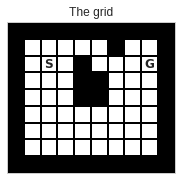

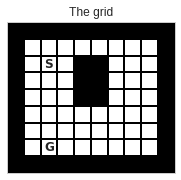

In [230]:
grid = Grid()
alt_grid = AltGrid()

grid.plot_grid()
alt_grid.plot_grid()

# Step 3 - Policies

In [0]:
# uniformly random policy
def random_policy(q):
  return np.random.randint(4)

# epilson-greedy policy
def epsilon_greedy(q_values, epsilon=0.1):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

# Step 4 - Helper

In [0]:
map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
      
  
def smooth(x, window=10):
  return x[:window*(len(x)//window)].reshape(len(x)//window, window).mean(axis=1)
  

def plot_stats(stats, window=10):
  plt.figure(figsize=(16,4))
  plt.subplot(121)
  xline = range(0, len(stats.episode_lengths), window)
  plt.plot(xline, smooth(stats.episode_lengths, window=window))
  plt.ylabel('Episode Length')
  plt.xlabel('Episode Count')
  plt.subplot(122)
  plt.plot(xline, smooth(stats.episode_rewards, window=window))
  plt.ylabel('Episode Return')
  plt.xlabel('Episode Count')

In [0]:
def run_experiment(env, agent, number_of_steps):
    print(number_of_steps)
    mean_reward = 0.
    try:
      action = agent.initial_action()
      
    except AttributeError:
      action = 0
      
    for i in range(number_of_steps):
#       print('------------------------------')
#       print('action: ', action)            
      
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)
     
#       print('rew: ', reward, ' dis: ', discount, ' next: ', next_state) 
#       print('neuAct: ', action)      
#       print('Neurew: ', mean_reward)
#       print('Q: ', agent._q)
#       print('------------------------------')      

    return mean_reward

In [0]:
def plot_policy(grid, policy):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  grid.plot_grid()
  plt.title('Policy Visualization')
  for i in range(9):
    for j in range(10):
      action_name = action_names[policy[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  plt.title('Greedy Policy')
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

# Step 5 - Agent

In [0]:

class PolicyEval_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, evaluated_policy, 
      behaviour_policy=random_policy, step_size=0.1): 
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._evaluated_policy = evaluated_policy
    self._action = 0
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    next_a = self._evaluated_policy(self._q[next_s])
    
    td_error = r + g * self._q[next_s, next_a] - self._q[s, a]
    self._q[s, a] += self._step_size * td_error

    self._state = next_state
    self._action = self._behaviour_policy(self._q[next_state])            
    return self._action

In [0]:
class QLearning_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state,
      behaviour_policy, step_size=0.1): 
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._action = 0
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    next_a = self._behaviour_policy(self._q[next_s])
    
    # Online Q-value update
    td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]
    self._q[s, a] += self._step_size * td_error

    # Act
    self._state = next_state
    self._action = self._behaviour_policy(self._q[next_state])
    return self._action

# Step 6 - Run

## Run Random Policy

100000
AFTER 100000 STEPS ...


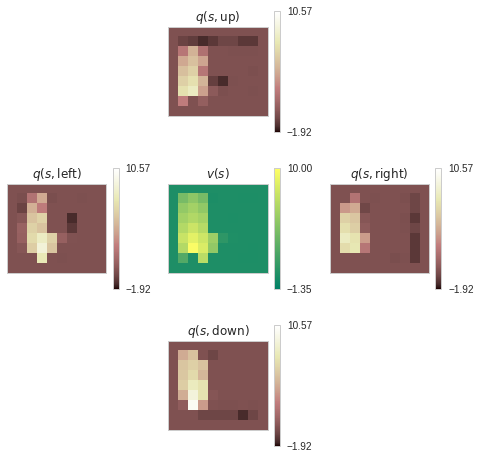

In [237]:
num_steps = int(1e5) 
# num_steps = int(20) 

# environment
grid = AltGrid()

# agent 
agent = PolicyEval_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
#     evaluated_policy=random_policy,
#     behaviour_policy=random_policy,
    evaluated_policy=epsilon_greedy,
    behaviour_policy=epsilon_greedy,
    step_size=0.1)

run_experiment(grid, agent, num_steps)

q = agent.q_values.reshape(grid._layout.shape + (4,))

print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q)

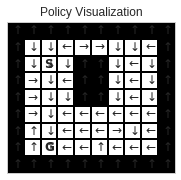

In [238]:
pi = np.zeros(grid._layout_dims, dtype=np.int32)
for i in range(grid._layout_dims[0]):
  for j in range(grid._layout_dims[1]):
    pi[i, j] = epsilon_greedy(q[i, j], epsilon=0.)
    
plot_policy(grid, pi)

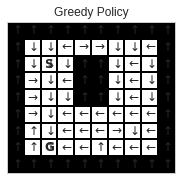

In [239]:
plot_greedy_policy(grid, q)

## Run QLearner

In [0]:
grid = Grid(discount=0.9, penalty_for_walls=-1.)

100000
AFTER 100000 STEPS ...


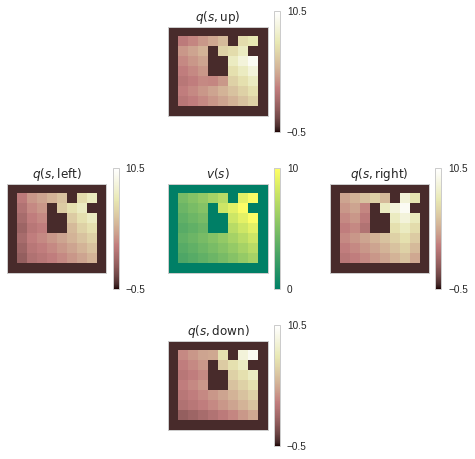

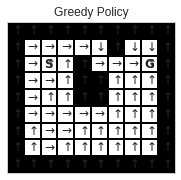

In [241]:
epsilon = 1.0 
num_steps = int(1e5) 

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# agent
agent = QLearning_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    behaviour_policy=behavior_policy,
    step_size=0.1)

run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q)

plot_greedy_policy(grid, q)

# Step 7 - Own Policy 

In [0]:
!pip install -q dm-sonnet

In [0]:
import sonnet as snt

## (Vanilla) Policy

In [0]:
Logging_EpStats = namedtuple("Logging_EpStats", 
                             ["episode_lengths", "episode_rewards"])    
Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "discount"])

In [0]:
class PolicyApproximator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, num_actions=4, learning_rate=0.01, scope="policy_approximation"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            
            state_one_hot = tf.one_hot(self.state, int(grid._layout.size))
            
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            
            self.return_s = tf.placeholder(dtype=tf.float32, name="return")
            
            nn_transform = snt.Linear(num_actions,
                          initializers={'w': tf.zeros_initializer,
                                        'b': tf.zeros_initializer})
            self.output_layer = nn_transform(tf.expand_dims(state_one_hot, 0))

            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            self.selected_action_prob = self.action_probs[self.action]#tf.gather(self.action_probs, self.action)

            self.loss = -tf.log(self.selected_action_prob) * self.return_s

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
      sess = sess or tf.get_default_session()
      pi_a_s = sess.run(self.action_probs, { self.state: state })
      return pi_a_s

    def update(self, state, return_s, action, sess=None):
      sess = sess or tf.get_default_session()
      feed_dict = { self.state: state, self.return_s: return_s, self.action: action  }
      _, loss = sess.run([self.train_op, self.loss], feed_dict)
      return loss

In [0]:
class REINFORCE_AGENT(object):
  
  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      policy_learning_rate=0.01, const_discount=1.0):
    
    self._policy_approximator = PolicyApproximator(num_actions=number_of_actions,
                                                   learning_rate=policy_learning_rate)
    self._constant_discount = const_discount 
    
    self._state = initial_state
    self._action = 0
    
  def step(self, state):
    action_probs = self._policy_approximator.predict(state)
    
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
    
    self._action = action
    self._state = state
    return self._action
    
  def update(self, episode):
    for t, transition in enumerate(episode):

      discounted_return = sum(self._constant_discount**i * t.reward for i, t in enumerate(episode[t:]))
      
      self._policy_approximator.update(transition.state, discounted_return, transition.action)

In [0]:
def run_reinforce(env, agent, num_episodes, 
                  MAXSTEPS_PER_EPISODE=100, 
                  REPORT_EVERY_N_STEPS=20):
    # Booking
    stats = Logging_EpStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
      
        action = 0#agent.initial_action()
        reward, discount, next_state = env.step(action)
        
        episode = []
        act_small = []
        
        state = next_state
        for t in range(MAXSTEPS_PER_EPISODE): 
            
            action = agent.step(state)
            reward, discount, next_state = env.step(action)
            
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, discount=discount))
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # (Live) reporting
            if ((discount == 0) | (t==MAXSTEPS_PER_EPISODE-1)) & (i_episode%REPORT_EVERY_N_STEPS==0):
                print("Episode {}/{}: Length {} ({})".format(
                i_episode + 1, num_episodes, t, stats.episode_rewards[i_episode - 1]))

            if discount == 0:         
                break
                
            state = next_state
    
        agent.update(episode)
         
    return stats, episode

## Run

In [0]:
grid = Grid(discount=1.0)

In [0]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)

agent = REINFORCE_AGENT(number_of_states=grid._layout.size,
                        number_of_actions=4, 
                        initial_state=grid.get_obs(), 
                        policy_learning_rate=0.01, 
                        const_discount=1.0)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    stats = run_reinforce(grid, agent, 500)

In [270]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)

agent = REINFORCE_AGENT(number_of_states=grid._layout.size,
                        number_of_actions=4, 
                        initial_state=grid.get_obs(), 
                        policy_learning_rate=0.01, 
                        const_discount=1.0)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    stats, actions = run_reinforce(grid, agent, 500)
    
    predict, predict_actions = run_reinforce(grid, agent, 1)    

Episode 1/500: Length 74 (0.0)
Episode 21/500: Length 40 (-120.0)
Episode 41/500: Length 84 (-20.0)
Episode 61/500: Length 22 (-95.0)
Episode 81/500: Length 11 (-5.0)
Episode 101/500: Length 20 (0.0)
Episode 121/500: Length 11 (-10.0)
Episode 141/500: Length 21 (5.0)
Episode 161/500: Length 8 (-15.0)
Episode 181/500: Length 9 (-10.0)
Episode 201/500: Length 6 (-5.0)
Episode 221/500: Length 10 (0.0)
Episode 241/500: Length 11 (0.0)
Episode 261/500: Length 6 (10.0)
Episode 281/500: Length 8 (10.0)
Episode 301/500: Length 6 (5.0)
Episode 321/500: Length 7 (10.0)
Episode 341/500: Length 6 (10.0)
Episode 361/500: Length 6 (10.0)
Episode 381/500: Length 7 (10.0)
Episode 401/500: Length 6 (10.0)
Episode 421/500: Length 6 (10.0)
Episode 441/500: Length 6 (5.0)
Episode 461/500: Length 6 (10.0)
Episode 481/500: Length 6 (10.0)
Episode 1/1: Length 6 (10.0)


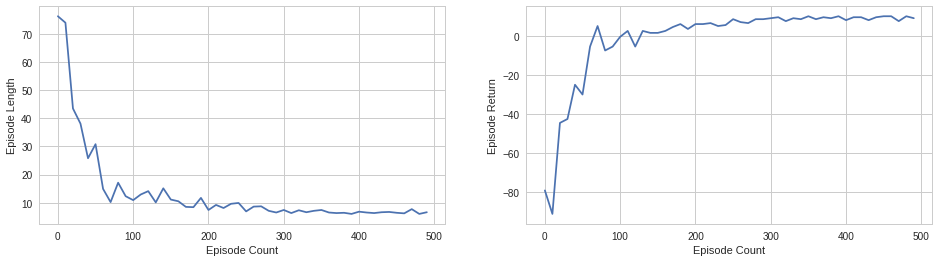

In [271]:
plot_stats(stats, window=10)

In [272]:
predict_actions

[Transition(state=12, action=1, reward=0.0, next_state=13, discount=1.0),
 Transition(state=13, action=1, reward=0.0, next_state=14, discount=1.0),
 Transition(state=14, action=1, reward=0.0, next_state=15, discount=1.0),
 Transition(state=15, action=2, reward=0.0, next_state=25, discount=1.0),
 Transition(state=25, action=1, reward=0.0, next_state=26, discount=1.0),
 Transition(state=26, action=1, reward=0.0, next_state=27, discount=1.0),
 Transition(state=27, action=1, reward=10, next_state=22, discount=0.0)]

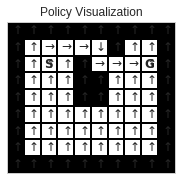

In [273]:
pi = np.zeros(grid._layout_dims, dtype=np.int32)

for i in range(len(predict_actions)):
  step = int(predict_actions[i].state)
  action = int(predict_actions[i].action) 
  y = int(step/10)
  x = step%10
  pi[y, x] = action
  
plot_policy(grid, pi)